<h2>Using Logistic Regression in TensorFlow</h2>


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
# Load the Iris inbuilt dataset
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

Now we define x and y. These placeholders will hold our iris data (both the features and label matrices), and help pass them along to different parts of the algorithm. You can consider placeholders as empty shells into which we insert our data. We also need to give them shapes which correspond to the shape of our data. Later, we will insert data into these placeholders by “feeding” the placeholders the data via a “feed_dict” (Feed Dictionary).
This feature of TensorFlow allows us to create an algorithm which accepts data and knows something about the shape of the data without knowing the amount of data going in. When we insert “batches” of data in training, we can easily adjust how many examples we train on in a single step without changing the entire algorithm.

In [6]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]

# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris has 4 features, so X is a tensor to hold our data.
yGold = tf.placeholder(tf.float32, [None, numLabels]) # This will be our correct answers matrix for 3 classes.

Here, we initialize both weights <code>W</code> and bias <code>b</code> as tensors full of zeros. Since we are going to learn <code>W</code> and <code>b</code>, their initial value does not matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they have been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training. 

Notice that <code>W</code> has a shape of [4, 3] because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. <code>b</code> has a shape of [3] so we can add it to the output. Moreover, unlike our placeholders above which are essentially empty shells waiting to be fed data, TensorFlow variables need to be initialized with values, e.g. with zeros.

In [7]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [8]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))


We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

The three main components here are: 
- a weight times features matrix multiplication operation, 
- a summation of the weighted features and a bias term, 
- and finally the application of a sigmoid function. 



In [9]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

The function we are going to use is the <i>logistic function</i> $(\frac{1}{1+e^{-Wx}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the <code>nn.sigmoid</code> function. Effectively, this fits the weighted input with bias into a 0-100 percent curve, which is the required probability function.

<a id="ref3"></a>
<h2>Training</h2>

The learning algorithm is how we search for the best weight vector (${\bf w}$). This search is an optimization problem looking for the hypothesis that optimizes an error/cost measure.

The Cost or Loss of the model, we want is to minimize that. Cost or loss tells us how good/bad the model is. The cost function we are going to utilize is the Squared Mean Error loss function. To minimize the cost function, here, we will use <a href="http://en.wikipedia.org/wiki/Gradient_descent">gradient descent</a> instead. Specifically, we will use batch gradient descent which calculates the gradient from all data points in the data set.

Before defining the cost function, we need to define how long we are going to train and how should we define the learning rate.

In [10]:
# Number of Epochs in training
numEpochs = 700

# Define learning rate for the training iterations (essentially decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [11]:
# Defining our cost function - Squared Mean Error
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

# Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP) 

Now we move on to actually running our operations. 

First, we need to initialize our weights and biases with zeros or random values via the inbuilt Initialization Operation (Op), <b>tf.initialize_all_variables()</b>. This Initialization Operation (Op) will become a node in our computational graph, and when we put the graph into a session, then the Op will run and create the variables.

In [12]:
# Create a tensorflow session
sess = tf.Session()

# Initialize the weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

We need some additional operations to keep track of our model's efficiency over time. 

In [13]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

Now we can define and run the actual training loop.

In [14]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: trainX, yGold: trainY})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.333333, cost 34.2552, change in cost 34.2552
step 10, training accuracy 0.616162, cost 29.9943, change in cost 4.2609
step 20, training accuracy 0.646465, cost 28.0598, change in cost 1.93447
step 30, training accuracy 0.646465, cost 26.4322, change in cost 1.62753
step 40, training accuracy 0.646465, cost 25.0825, change in cost 1.34971
step 50, training accuracy 0.646465, cost 23.9685, change in cost 1.11406
step 60, training accuracy 0.646465, cost 23.0465, change in cost 0.921938
step 70, training accuracy 0.646465, cost 22.2783, change in cost 0.768196
step 80, training accuracy 0.646465, cost 21.6324, change in cost 0.645931
step 90, training accuracy 0.646465, cost 21.0838, change in cost 0.548582
step 100, training accuracy 0.656566, cost 20.6132, change in cost 0.470669
step 110, training accuracy 0.666667, cost 20.2053, change in cost 0.407856
step 120, training accuracy 0.666667, cost 19.8485, change in cost 0.356775
step 130, training accuracy 0.

We plot the cost to see how it behaves across training steps.

In [17]:
len(cost_values)

70

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


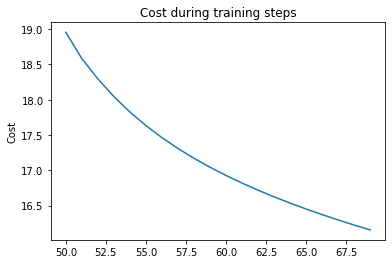

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.ylabel('Cost')
plt.title('Cost during training steps')
plt.show()